###### cMDS

Carga de las librerías iniciales:

In [1]:
import pandas as pd
import numpy as np
import pytraj as pyt
import matplotlib.pyplot as plt
import glob, sys, os
sys.path.append(r'..')

### Tabla con los datos de las estructuras cristalográficas

In [2]:
prot_name = 'erk2'

In [58]:
path_string_list = '../data/TABLA_MTDATA_ERK2_166_crys_LIGS_INFO.json'.split('/')
path_to_json_file = glob.glob(os.path.join(*path_string_list))[0]

df_prot = pd.read_json(path_to_json_file)
df_prot

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass
1erk,structure of signal-regulated kinase,1997-05-15,1,A,2.30,355,99.166667,1,[3],"[[1, 3]]",0,[],None,NaN
1gol,coordinates of rat map kinase erk2 with an arg...,1997-03-12,1,A,2.80,354,99.166667,1,[3],"[[1, 3]]",2,"[ATP, MG]",ATP,398.0
1pme,structure of penta mutant human erk2 map kinas...,1999-06-08,1,A,2.00,354,92.500000,4,"[15, 3, 1, 8]","[[1, 15], [33, 35], [161, 161], [330, 337]]",3,"[CME, SB2, SO4]",SB2,342.0
1tvo,the structure of erk2 in complex with a small ...,2005-09-13,1,A,2.50,360,97.222222,2,"[7, 3]","[[1, 7], [358, 360]]",1,[FRZ],FRZ,314.0
1wzy,crystal structure of human erk2 complexed with...,2005-12-20,1,A,2.50,360,97.222222,2,"[7, 3]","[[1, 7], [358, 360]]",1,[F29],F29,350.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6qag,erk2 mini-fragment binding,2019-03-27,1,A,2.07,359,94.166667,4,"[10, 1, 7, 3]","[[1, 10], [161, 161], [331, 337], [358, 360]]",3,"[CME, HUH, SO4]",None,NaN
6qah,erk2 mini-fragment binding,2019-06-26,1,A,1.58,359,94.166667,5,"[10, 1, 1, 6, 3]","[[1, 10], [36, 36], [161, 161], [332, 337], [3...",3,"[CME, HVB, SO4]",None,NaN
6qal,erk2 mini-fragment binding,2019-03-27,1,A,1.57,359,93.055556,5,"[10, 3, 1, 8, 3]","[[1, 10], [34, 36], [161, 161], [331, 338], [3...",3,"[CME, HV2, SO4]",HV2,122.0
6qaq,erk2 mini-fragment binding,2019-03-27,1,A,1.58,359,95.277778,4,"[10, 1, 3, 3]","[[1, 10], [161, 161], [331, 333], [358, 360]]",3,"[CME, HVQ, SO4]",HVQ,114.0


### Carga de las 166 estructuras de la proteína
El archivo a cargar es un único archivo `.pdb` generado desde `vmd` (pudo haber sido creado don cualquier otro método) a partir de las 166 estructuras obtenidas del PDB.

In [4]:
path_string_to_pdb_traj = '../../ARCHIVOS/CRISTALES/TRAJ_CRISTALS_PDB/\
PDB_166_erk2_ALIGN_BY_SEC_STRUC_all.pdb'.split("/")

# Carga de la trayectoria de estructuras cristalograficas
file_pdb_traj_pisani = os.path.join(*path_string_to_pdb_traj)
traj_crystals = pyt.load(file_pdb_traj_pisani)

print(F'Número de frames: {traj_crystals.n_frames}.\nNúmero de átomos: {traj_crystals.n_atoms}.')

Número de frames: 166.
Número de átomos: 5830.


## Visualización de la estructura secundaria de la proteína
Vamos a construir el cMDS utilizando ciertos residuos de la proteína:

In [5]:
import prody
# usaremoa una estructura de referencia:
path_to_ref_prot = '../../ARCHIVOS/CRISTALES/PROT_ERK2_PREPARADAS/PREP_ALL_ENSAMBLE/1gol_ENS.pdb'.split('/')
path_to_ref_prot_file = os.path.join(*path_to_ref_prot)
ref_prot = prody.parsePDB(path_to_ref_prot_file)

@> 5830 atoms and 1 coordinate set(s) were parsed in 0.05s.


Cargamos la lista de residuos que conforman la estructura secundaria de la proteína:

In [6]:
path_to_list_residues = '../data/list_erk2_secondary_structure_residues.txt'.split('/')
with open(os.path.join(*path_to_list_residues)) as f:
    sec_struc_residues_string = f.read()

Llevamos a cabo la selección de los átomos:

In [7]:
# Seleccionamos todos los átomos de los residuos en selected_residues
pocket_atoms = ref_prot.select(F'resnum {sec_struc_residues_string}')
# Obtenemos los índices de los átomos
pocket_atoms_index = pocket_atoms.getIndices()

In [8]:
import nglview as nv
# Llevamos a cabo la visualización
view = nv.show_prody(ref_prot)
view.clear_representations()
view.add_representation('cartoon', selection = 'protein', color = 'white')
view.add_cartoon(selection = pocket_atoms_index, color='red')
view

_ColormakerRegistry()

NGLWidget()

&nbsp;
## Classical Multidimentional Scaling
### Matriz de disimilitud
#### RMSD alineando por residuos usados por Pisani
Utilizamos *pytraj* para generar la matrix de disimilitud con la métrica *RMSD* en las **255** estructuras usadas por Pisani.

In [44]:
# Máscara indicando los CA de los residuos de Pisani
sec_struc_residues_string_csv = sec_struc_residues_string.replace(' ', ',')
residues_mask = F":{sec_struc_residues_string_csv}&@CA"

# RMSD por pares de las 402 estructuras
pair_rmsd_166_struc = pyt.pairwise_rmsd(traj = traj_crystals, 
                                        mask= residues_mask, metric="rms")

In [51]:
import seaborn as sns
sns.set(context = 'talk', style = 'white')

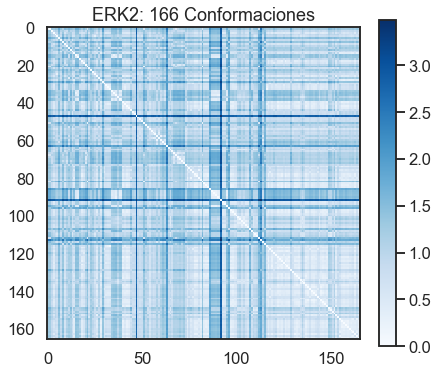

In [52]:
%matplotlib inline
# visualizamos la matriz D
fig = plt.figure(figsize=(7, 6))
plt.rcParams.update({'font.size': 20})
plt.title("ERK2: 166 Conformaciones")
plt.imshow(pair_rmsd_166_struc, zorder=2, cmap='Blues')
plt.colorbar();

In [53]:
from modules.MDS import cMDS
from modules.plotting_functions import plot_points, plot_anotation_labels

In [54]:
mds_sec_all = cMDS(pair_rmsd_166_struc)

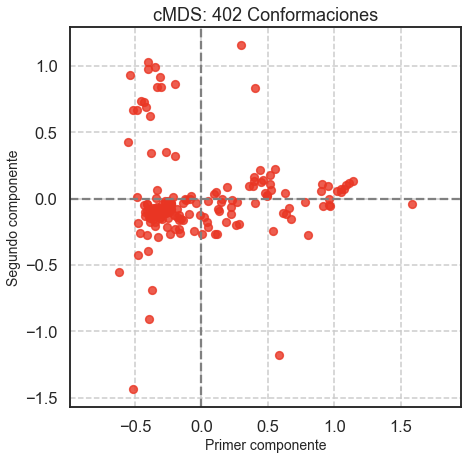

In [57]:
fig = plt.figure(figsize=(7, 7))
plot_points(mds = mds_sec_all[0], alpha=0.8,
                             title = "cMDS - ERK2:")

### MDS con todos los átomos

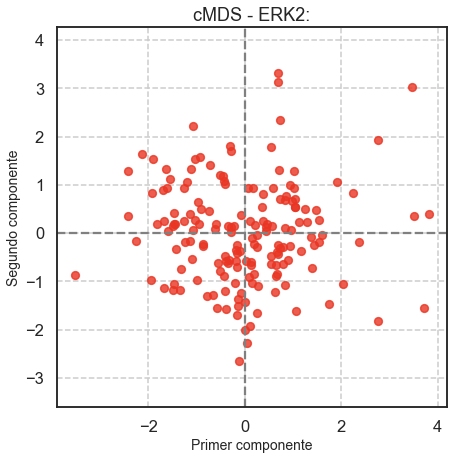

In [59]:
pair_rmsd_166_all = pyt.pairwise_rmsd(traj = traj_crystals, metric="rms")
mds_all_atoms = cMDS(pair_rmsd_166_all)

fig = plt.figure(figsize=(7, 7))
plot_points(mds = mds_all_atoms[0], alpha=0.8,
                             title = "cMDS - ERK2:")

In [73]:
new_residues = sec_struc_residues_string.split(' ')
string_new_res = ','.join(new_residues[:-90])
string_new_res

'13,14,17,18,25,26,27,28,29,30,31,32,33,38,39,40,41,42,43,44,49,50,51,52,53,54,55,56,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,88,89,90,101,102,103,104,105,106,110,111,112,113,114,115,116,117,118,119,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,145,146,155,156,157,163,164,165'

In [75]:
new_residues = sec_struc_residues_string.split(' ')
string_new_res_1 = ' '.join(new_residues[:-80])
string_new_res_2 = ','.join(new_residues[:-80])

# Seleccionamos todos los átomos de los residuos en selected_residues
pocket_atoms = ref_prot.select(F'resnum {string_new_res}')
# Obtenemos los índices de los átomos
pocket_atoms_index = pocket_atoms.getIndices()

view = nv.show_prody(ref_prot)
view.clear_representations()
view.add_representation('cartoon', selection = 'protein', color = 'white')
view.add_cartoon(selection = pocket_atoms_index, color='red')
view

NGLWidget()

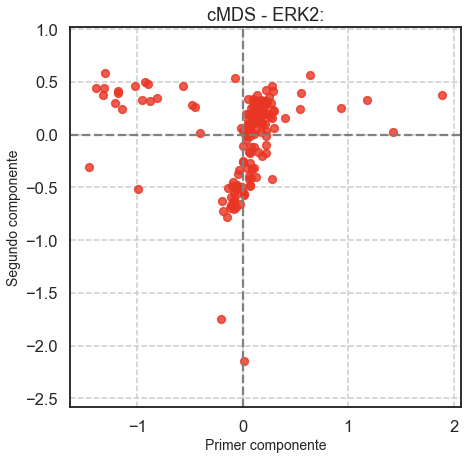

In [77]:
residues_mask = F":{string_new_res_2}&@CA"

pair_rmsd_166_all = pyt.pairwise_rmsd(traj = traj_crystals, metric="rms", mask = residues_mask)
mds_all_atoms = cMDS(pair_rmsd_166_all)

fig = plt.figure(figsize=(7, 7))
plot_points(mds = mds_all_atoms[0], alpha=0.8,
                             title = "cMDS - ERK2:")